In [1]:
# Loading mmodules
%matplotlib inline

import matplotlib.pyplot as plt # for plotting
import numpy as np
import math
from scipy.spatial.distance import pdist, squareform
import scipy.integrate as integrate 
from sklearn.neighbors import NearestNeighbors 
import os

#change directory to save output here
directory = r"D:\Users\Nick\Desktop\Everything\Uni\Honours Project\Plots\RosslerExamples/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))

C:\Users\nickb\AppData\Local\Temp/ipykernel_15176/3565999683.py:14: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))


In [3]:
def embedding_delay(y,m,delay):
    """Returns the trajectory matrix X from the 1-D array y,
            with delay=delay and embedding dimension=m"""
    N=y.shape[0]
    W=N-(m-1)*delay
    X=np.empty((W,m))

    for m_i in range(m):
        X[:,m_i]=y[m_i*delay:m_i*delay+W].copy()
        
    return X

from numba import jit
@jit(nopython=True)
def D_rossler(Y,t,F, a, b, c,):
    
    x1,y1,z1=Y[:]
    
    F[:]=[-y1 -z1,
          x1+a*y1,
          b + z1*( x1-c )]
    return F


def rossler(args):
    from scipy import integrate
    
    a, b, c ,Y0, max_time, dt, s_time=args
    
    F=np.empty_like(Y0)
    t = np.linspace(0, max_time, int((1/dt)*max_time))

    Yt = integrate.odeint(D_rossler, Y0, t,
                                 args=(F, a, b, c))

    return Yt[::int(s_time/dt), :]

def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I = Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

#to find FNN

def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = embedding_delay(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

In [10]:
# Dynamical system parameters
(a,b,c) = (0.3,2,4)

# Simulation parameters
h=0.001  # integration time (a.u)
Ts=0.1   # sampling rate(a.u)
Tperm=200 # permanent regime time duration (a.u)
Ttrans=500 # transient to be removed (a.u)



# SIMULATION ############################
Y0=[0.2, 0, 0]
rand_max, rand_min = 1, -1 #zero for identical initial conditions.
Y0 = Y0+ (rand_max - rand_min)*np.random.random_sample(3) - rand_max

args=[a, b, c, Y0, Tperm+Ttrans, h, Ts]
X1 = rossler(args)[int(Ttrans/Ts):,:] # decimating means sampling with sampling time Ts

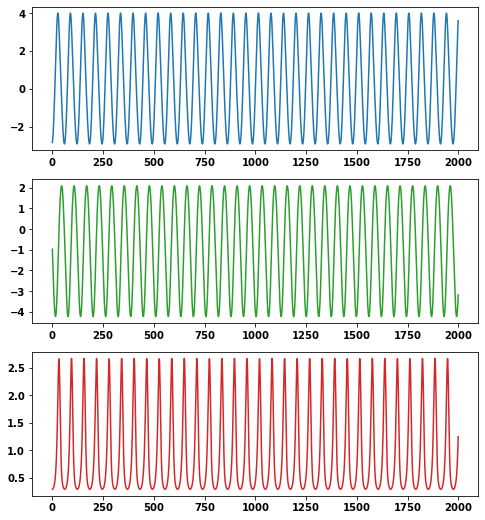

In [11]:
fig, axes = plt.subplots(3,1,figsize=(8,9))

axes = axes.ravel()
c_olors=['C0','C2','C3']
for i in range(3):
    axes[i].plot(X1[:,i],c=c_olors[i])
    

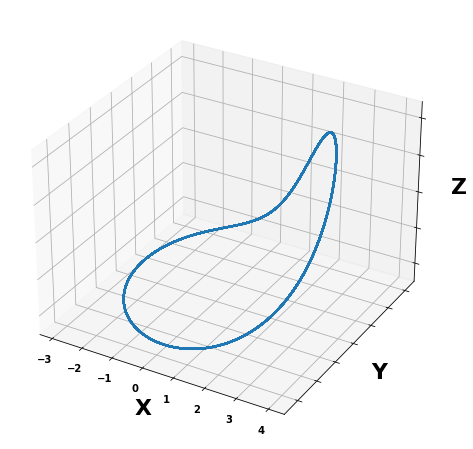

In [6]:
#plotting phase space


fig=plt.figure(figsize=(12,8))

ax=fig.add_subplot(111,projection="3d")
ax.plot(X1[:,0],X1[:,1],X1[:,2],c="C0",linewidth=2)


ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('X',fontsize=22)
ax.set_ylabel('Y',fontsize=22)
ax.set_zlabel('Z',fontsize=22)

name = "Rossler"+"_"+"a="+str(a)+"_"+"b="+str(b)+"_"+"c="+str(c)
plt.savefig(str(name)+".pdf",format="pdf",bbox_inches="tight")


This is the Delay for x: 3
This is the Delay for y: 5
This is the Delay for z: 0


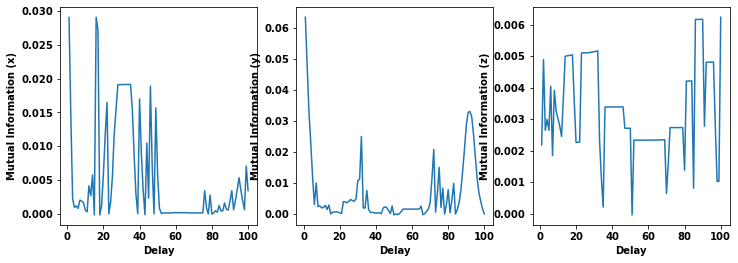

In [6]:
MI_x = []
MI_y = []
MI_z = []
n_bins = int(math.sqrt((len(X1))))

fig = plt.figure(figsize=(12,4))
for i in range(1,101):
    MI_x = np.append(MI_x,[mutualInformation(X1[:,0],i,n_bins)])
    MI_y = np.append(MI_y,[mutualInformation(X1[:,1],i,n_bins)])
    MI_z = np.append(MI_z,[mutualInformation(X1[:,2],i,n_bins)])
    
ax=fig.add_subplot(131)
ax.plot(range(1,101),MI_x,label="MI (x)")
ax.set_xlabel("Delay")
ax.set_ylabel("Mutual Information (x)")

ax=fig.add_subplot(132)
ax.plot(range(1,101),MI_y,label="MI (y)")
ax.set_xlabel("Delay")
ax.set_ylabel("Mutual Information (y)")

ax=fig.add_subplot(133)
ax.plot(range(1,101),MI_z,label="MI (z)")
ax.set_xlabel("Delay")
ax.set_ylabel("Mutual Information (z)")


#finding correct delay value
for i in range(len(MI_x)):
    if MI_x[i+1] > MI_x[i]: #first minimum
        print("This is the Delay for x:", i)
        delay_ts = i
        break
        
for i in range(len(MI_y)):
    if MI_y[i+1] > MI_y[i]: #first minimum
        print("This is the Delay for y:", i)
        delay_ts = i
        break
        
for i in range(len(MI_z)):
    if MI_z[i+1] > MI_z[i]: #first minimum
        print("This is the Delay for z:", i)
        delay_ts = i
        break

In [25]:
x_embed = embedding_delay(X1[:,0],3,14)
y_embed = embedding_delay(X1[:,1],3,15)
z_embed = embedding_delay(X1[:,2],3,8)



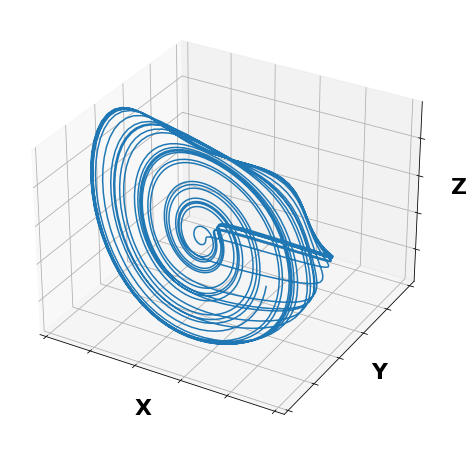

In [24]:

fig=plt.figure(figsize=(12,8))

ax=fig.add_subplot(111,projection="3d")
ax.plot(x_embed[:,0],x_embed[:,1],x_embed[:,2])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('X',fontsize=22)
ax.set_ylabel('Y',fontsize=22)
ax.set_zlabel('Z',fontsize=22)
plt.savefig("Rossler_x_embedding.pdf",format="pdf",bbox_inches="tight")



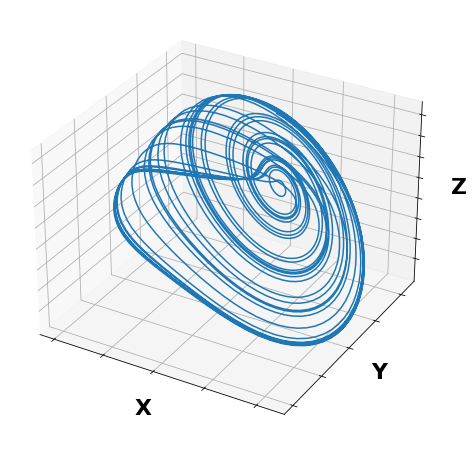

In [26]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111,projection="3d")
ax.plot(y_embed[:,0],y_embed[:,1],y_embed[:,2])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('X',fontsize=22)
ax.set_ylabel('Y',fontsize=22)
ax.set_zlabel('Z',fontsize=22)
plt.savefig("Rossler_y_embedding.pdf",format="pdf",bbox_inches="tight")

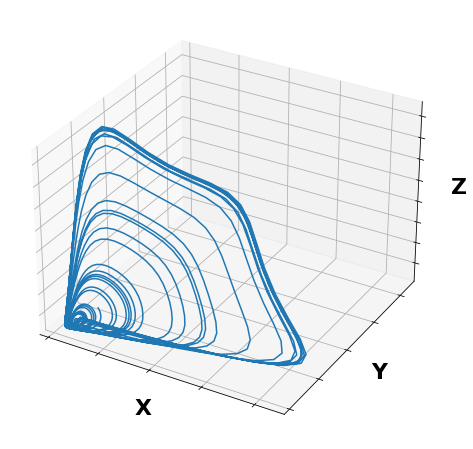

In [13]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111,projection="3d")
ax.plot(z_embed[:,0],z_embed[:,1],z_embed[:,2])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('X',fontsize=22)
ax.set_ylabel('Y',fontsize=22)
ax.set_zlabel('Z',fontsize=22)
plt.savefig("Rossler_z_embedding.pdf",format="pdf",bbox_inches="tight")